# View 페이지 작성

Django 의 View 는 화면과 모델의 중간 위치에 놓은 모듈로 비즈니스 로직을 담당 하는 파트 이다.

어플리케이션 구현을 위하여 다음과 같은 파일 작성을 시도하여 본다.

- index : Question 에 관한 기본 정보를 보여주는 페이지.
- detail : Question 에 관한 상세 정보를 보여주는 페이지.
- result : Question 투표 결과를 보여주는 페이지
- vote action : 투표 액션을 구현하는 모듈

## 1. Views 파일 작성

Views.py 파일 내에 요청 유형별로 HttpResponse 가능한 함수를 내용별로 분류하여 각 작성한다.

In [2]:
# 아래와 같이 view.py 를 재정의하였다.
!cat ../polls/views.py

from django.shortcuts import render
from django.http import HttpResponse

def index(request):
    return HttpResponse("Hello, World. You are at the polls index.")

def detail(request, question_id):
    return HttpResponse("You are looking at question %s." % question_id)
    
def results(request, question_id):
    response = "You are looking at the results of question %s."
    return HttpResponse(response % question_id)
    
def vote(request, question_id):
    return HttpResponse("You are voting on question %s." % question_id)


## 2. 작성된 페이지 정보를 URL에 등록

In [3]:
# 앞서 작성한 view 와 urls 을 연결 시킨다.
!cat ../polls/urls.py

from django.urls import path
from . import views

urlpatterns = [
    # ex: /polls/
    path('', views.index, name='index'),
    
    # ex: /polls/5/
    path('<int:question_id>/', views.detail, name='detail'),
    
    # ex: /polls/5/results/
    path('<int:question_id>/results/', views.results, name='results'),
    
    # ex: /polls/5/vote/
    path('<int:question_id>/vote/', views.vote, name='vote'),
]


### URL 별 접속 결과 확인
http://127.0.0.1:8000/polls/
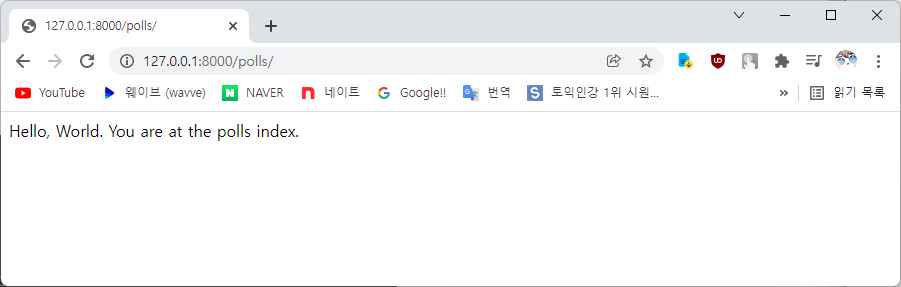

http://127.0.0.1:8000/polls/1/
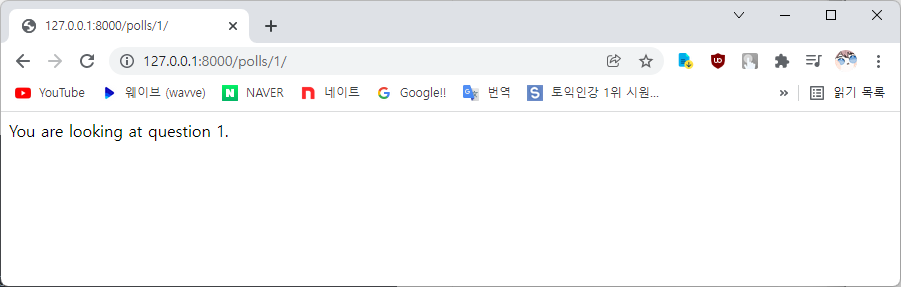

## 3. Views.py 파일에 접속 URL 별 기능 구현 하기
페이지 리다이렉션을 확인 한 지금. 실제 동작하는 기능을 기술하여 본다.

In [5]:
# index 함수는 저장된 데이터를 pub_date 를 기준으로 정렬하여 제공한다.
!cat ../polls/views.py

from django.shortcuts import render
from django.http import HttpResponse

from .models import Question

def index(request):
    latest_question_list = Question.objects.order_by('-pub_date')[:5]
    output = ', '.join([q.question_text for q in latest_question_list])
    return HttpResponse(output)

def detail(request, question_id):
    return HttpResponse("You are looking at question %s." % question_id)
    
def results(request, question_id):
    response = "You are looking at the results of question %s."
    return HttpResponse(response % question_id)
    
def vote(request, question_id):
    return HttpResponse("You are voting on question %s." % question_id)


### 관리자 페이지를 통한 데이터 추가 확보

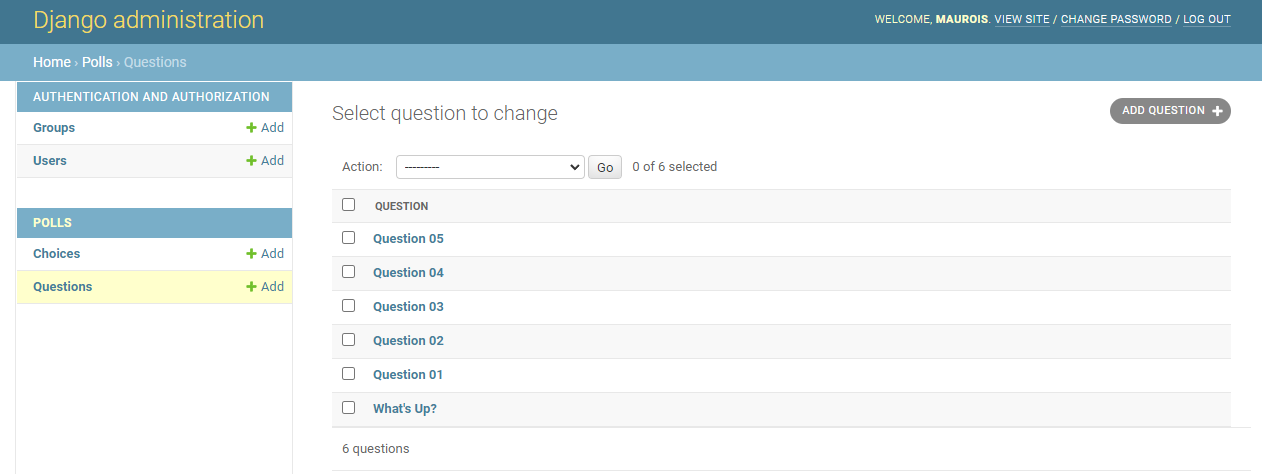

### 등록 시간이 가장 최근 순으로 5건이 출력된다.
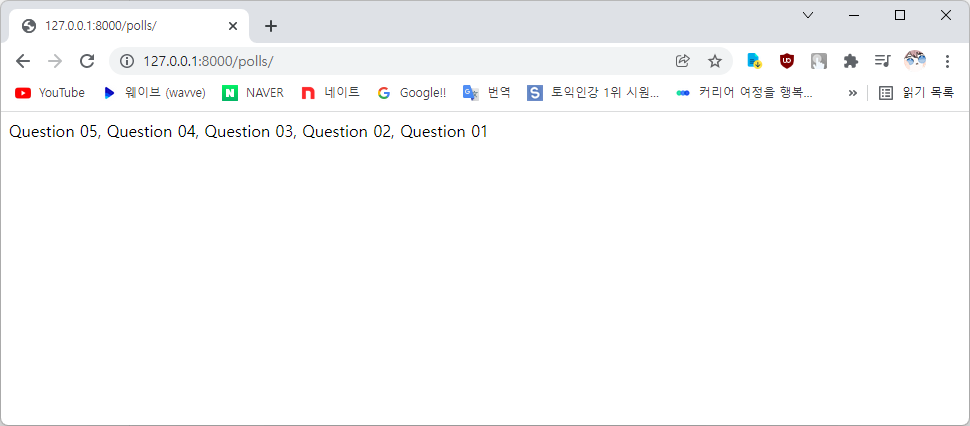

## 4. Template 을 이용한 데코레이션

Template은 HTML 코드 일부를 파이썬 코드로 작성할 수 있다. 또한 Template 파일은

**[APP]/templates/[APP]/template_file** 형태로 존재하게 된다.

[APP] 폴더가 반복되는 이유는 Django 가 Template 파일 검색이 APP 별로 보유중인 templates 폴더를 모두 검색하기 때문에 각 APP 간 동일 파일 명의 중첩을 피하기 위하여 폴더를 분리하여 저장하게 되었으며, 이를 template namespacing 이라고 부른다.

In [9]:
# 작성된 html 파일 확인
!cat ../polls/templates/polls/index.html

{% if latest_question_list %}
	<!-- ul tag start -->
	<ul>
	{% for question in latest_question_list %}
		<!-- li tag start -->
		<li>
			<a href="/polls/{{ question.id }}">{{ question.question_text }} </a>
		</li>
		<!-- li tag end -->
	{% endfor %}
	</ul>
	<!-- ul tag end -->
{% else %}
	<p>No polls are available. </p>
{% endif %}


## 5. 렌더링을 위한 Views.py 수정
작업된 template 을 response 응답 객체에 전달하기 위해서는 랜더링 과정이 필요하다.


```python
from django.template import loader
def index(request):
    latest_question_list = Question.objects.order_by('-pub_date')[:5]
    template = loader.get_template('polls/index.html')
    context = {
        'latest_quesiton_list' : latest_question_list,
    }
    return HttpResponse(template.render(context, request))
```

#### DB 에 저장된 데이터와 투표 URL을 결합한 페이지가 랜더링 된다.

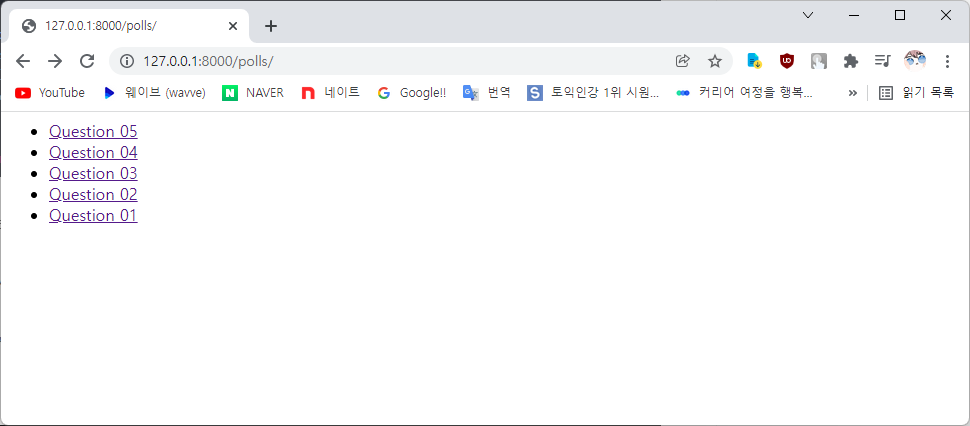


#### rendering 위한 함수
상기 HttpResponse(template.render(context, request)) 함수는 아래와 같이 **render() 함수**의 형태로도 사용 가능하다. 

```python
def index(request):
    latest_question_list = Question.objects.order_by('-pub_date')[:5]
    context = {'latest_question_list': latest_question_list}
    return render(request, 'polls/index.html', context)
```

## 6. try: except 블록을 이용하여 404 에러 대응하기
서버 로직에는 예외상황에 대응 가능한 예외처리 로직 적용이 가능하다



```python
from django.http import Http404
def detail(request, question_id):
    try:
        question = Question.objects.get(pk=question_id)
    except Question.DoesNotExist:
        raise Http404("Question does not exist")
    return render(request, 'polls/detail.html', {'question': question})
```

In [10]:
# detail 함수 확인
!cat ../polls/Views.py

from django.shortcuts import render
from django.http import HttpResponse
from django.template import loader

from .models import Question
from django.http import Http404

def index(request):
    latest_question_list = Question.objects.order_by('-pub_date')[:5]
    template = loader.get_template('polls/index.html')
    context = {
        'latest_question_list' : latest_question_list,
    }
    return HttpResponse(template.render(context, request))

def detail(request, question_id):
    try:
        question = Question.objects.get(pk=question_id)
    except Question.DoesNotExist:
        raise Http404("Question does not exist")
    return render(request, 'polls/detail.html', {'question':question})
    
def results(request, question_id):
    response = "You are looking at the results of question %s."
    return HttpResponse(response % question_id)
    
def vote(request, question_id):
    return HttpResponse("You are voting on question %s." % question_id)


In [13]:
# template 파일 확인
!cat ../polls/templates/polls/detail.html

{{ question}}


### 존재하는 ID 값의 상세 페이지 접근
http://127.0.0.1:8000/polls/5/

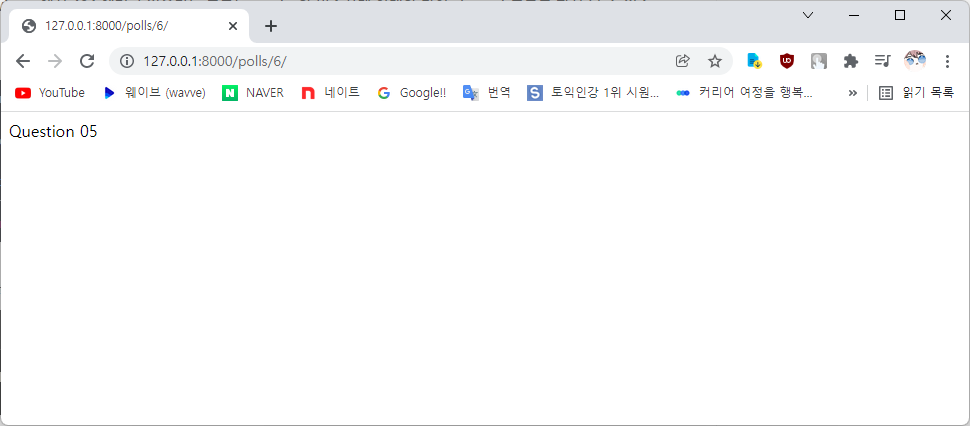

### 존재하지 않는 ID 호출을 통해 404 에러 발생 시키기
http://127.0.0.1:8000/polls/9/

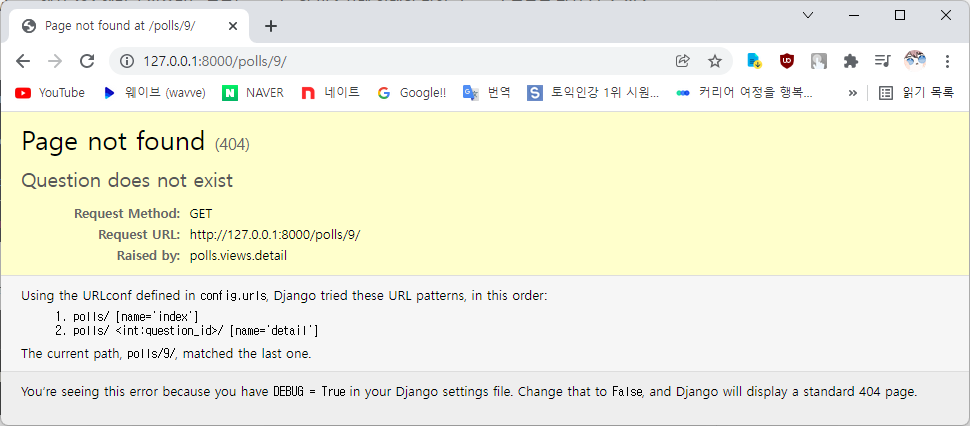

In [15]:
# detail.html 파일 완성 시키기
# template 파일 확인
!cat ../polls/templates/polls/detail.html

<h1>{{ question }}</h1>
<ul>
{% for choice in question.choice_set.all %}
	<li> {{ choice.choice_text }}</li>
{% endfor %}

</ul>


## 7. URL 하드코딩 제거하기

index.html Template 작성 당시 사용된 URL 은 하드코딩이였다. 해당 내용을 다음과 같이 바꿔 적용 가능하다.


**Before**
```python
<li><a href="/polls/{{ question.id }}/">{{ question.question_text }}</a></li>
```
**After**
```python
<li><a href="{% url 'detail' question.id %}">{{ question.question_text }}</a></li>
```

**입력 포맷** : {% url '(View URL name)' (Parameter) %]


### View URL Name
일전에 작성한 [APP]/urls.py 에 기술한 name 을 따라 간다.
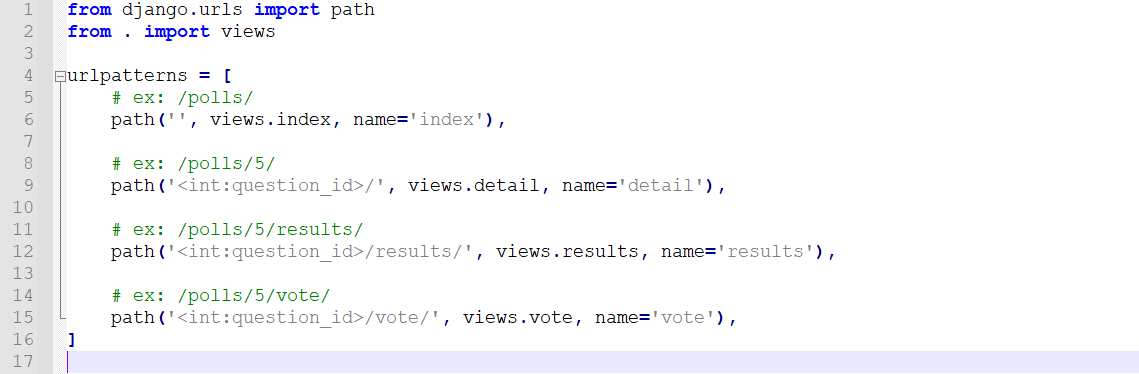

## 8. URL Namespacing

앞서 기술한 Template 의 내용 중 아래의 detail 과 같이,
```python 
<a href="{% url 'detail' question.id %}">
``` 
URL name 이 중복 되는 경우 정확한 URL Name 을 찾아 가기 위해 Namespacing 을 적용할 수 있다.  
Namespacing 을 적용하는 경우, 호출 경로 앞 app_name 을 같이 서술해 주어야 한다.

```python 
<a href="{% url 'polls:detail' question.id %}">
``` 

In [16]:
#  app_name 으로 Namespacing 을 적용
!cat ../polls/urls.py

from django.urls import path
from . import views

app_name = 'polls'

urlpatterns = [
    # ex: /polls/
    path('', views.index, name='index'),
    
    # ex: /polls/5/
    path('<int:question_id>/', views.detail, name='detail'),
    
    # ex: /polls/5/results/
    path('<int:question_id>/results/', views.results, name='results'),
    
    # ex: /polls/5/vote/
    path('<int:question_id>/vote/', views.vote, name='vote'),
]


In [17]:
!cat ../polls/templates/polls/index.html

{% if latest_question_list %}
	<!-- ul tag start -->
	<ul>
	{% for question in latest_question_list %}
		<!-- li tag start -->
		<li>
			<!-- <a href="/polls/{{ question.id }}">{{ question.question_text }} </a> -->
			<a href="{% url 'polls:detail' question.id %}">{{ question.question_text }} </a>
		</li>
		<!-- li tag end -->
	{% endfor %}
	</ul>
	<!-- ul tag end -->
{% else %}
	<p>No polls are available. </p>
{% endif %}


#### URL 통해 접속시 이전과 동일한 동작을 보장하는 것을 확인 할 수 있다.
http://127.0.0.1:8000/polls/ 